# All to all network Simulations

We simulate the whole network as an array and we reset it to the initial configuration following a Poisson process

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [19]:
@njit
def init_config(N):
    r = np.random.randint(0, 2, size=N)   # array of 0 or 1
    return 2*r - 1  

@njit
def voter_model_evolution(N, t, r):
    '''Takes:
    N: number of agents
    t: time in MC steps
    r: resetting rate per MC step
    
        Returns:
    config: The config at time t
    res: number of resets'''

    config = init_config(N)
    ini = config.copy()

    res = 0

    for _ in range(t):
        for _ in range(N):
            
            if np.random.rand() < r: #Try to reset
                config = ini.copy()
                res = res +1
                continue
            
            a = np.random.randint(N)
            b = np.random.randint(N-1)
            if b >= a:
                b += 1
            
            config[a] = config[b] #If no reset occurs, apply normal VM dynamics

    return(config, res)

## Check Poisson

In [21]:
@njit
def check_poisson(N, T, r, div, samples):
    '''Checks if the resetting is a poisson process.
    Takes the same arguments as the simulation plus:
    
    div: number of different times we sample
    samples: number of samples per time
    '''
    
    res = np.zeros(div)

    ts = np.linspace(0, T, div)

    for i in range(div):
        t = ts[i]

        total = 0.0
        for _ in range(samples):
            _, resets = voter_model_evolution(N, int(t), r) #Calculate resets up to time t
            total += resets

        res[i] = total / samples

    return res

Text(0, 0.5, 'Resets')

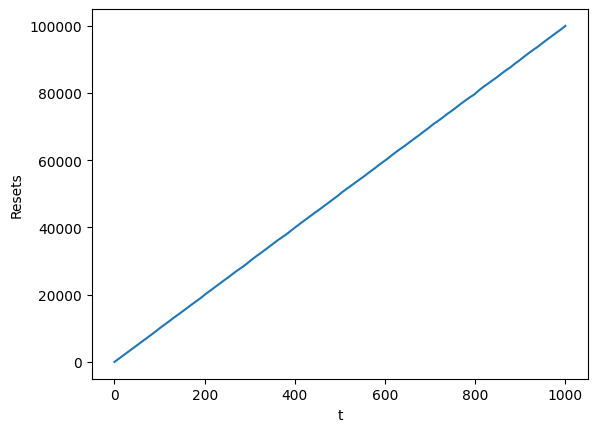

In [23]:
plt.plot(np.linspace(0, 1000, 100), check_poisson(1000, 1000, 0.1, 100, 50))
plt.xlabel("t")
plt.ylabel("Resets")

## Distribution of Magnetisation

In [20]:
@njit
def mag(config):
    '''Returns the magnetisation given the state configuration'''
    return(np.mean(config))

@njit
def dist(N, t, r, samples):
    '''Returns the magnetisation at time t for some samples'''
    res = np.zeros(samples)

    for i in range(samples):
        res[i] = mag(voter_model_evolution(N, t, r)[0])
    
    return res

(array([1059.,  182.,  218.,  276.,  259.,  294.,  336.,  429.,  440.,
         541.,  511.,  605.,  692.,  845.,  816.,  981., 1124., 1132.,
        1408., 1616., 1714., 1921., 2331., 2391., 2795., 2931., 2462.,
        2324., 1902., 1825., 1619., 1388., 1287., 1127., 1000.,  772.,
         795.,  625.,  629.,  555.,  465.,  398.,  391.,  327.,  300.,
         302.,  234.,  206.,  223.,  997.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

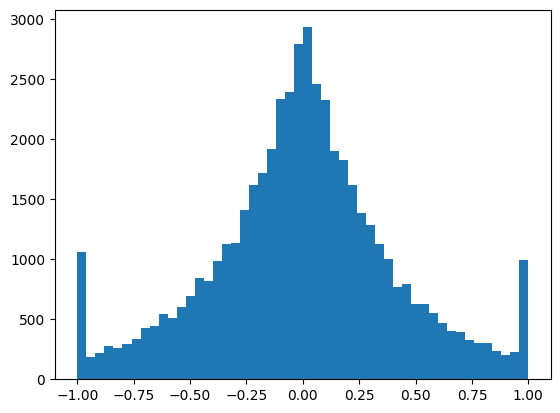

In [6]:
plt.hist(dist(1000, 1000, 0.01, 50000), bins = 50)

# Compare 

In [25]:
import sys
from importlib import reload
sys.path.append("../scripts")
import solution as sol


sol = reload(sol)

In [6]:
d = dist(1000, 1000, 0.01, 10000)

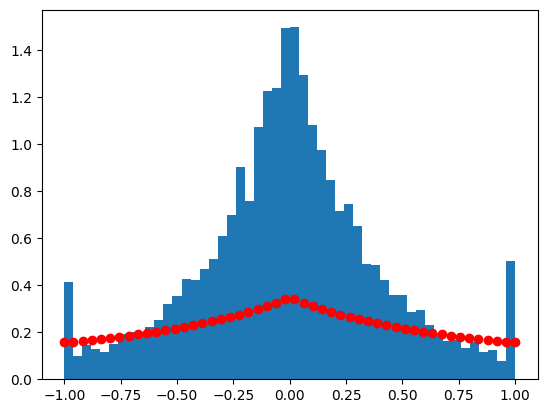

In [26]:
bins = 50
plt.hist(d, bins = bins, density=True)
plt.scatter(np.linspace(-1,1,bins), sol.sol(0.1,0,bins), color = "r")

